In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.IFS import polychromeIFS
from crispy.IFS import reduceIFSMap
from crispy.tools.imgtools import scale2imgs,bowtie
from crispy.tools.image import Image
from crispy.tools.rotate import rotateCube,shiftCube
from crispy.tools.postprocessing import mf,recenter_offaxis
from crispy.tools.inputScene import adjust_krist_header
from crispy.tools.detector import averageDetectorReadout
from astropy.io import fits
import astropy.units as u
from crispy.tools.postprocessing import construct_mflib,convolved_mf


Populating the interactive namespace from numpy and matplotlib
../../../../crispy


In [2]:
lamc=660.
BW = 0.18
par.nonoise=False
sampling=2.0
par.timeframe=10000
par.Nreads = par.timeframe/100.
par.PCmode=True
par.EMStats=True
par.poisson=True
par.lifefraction = 0.0
par.lenslet_sampling=1./sampling
folder = '/Users/mrizzo/IFS/OS5_SIM_'+str(sampling)+'_t'+str(int(par.timeframe))
# folder = '/Users/mrizzo/IFS/OS5_SIM_'+str(sampling)+'_noiseless'
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
OS5_files = '/Users/mrizzo/IFS/OS5/with_lowfc/'

try:
    os.makedirs(folder)
    os.makedirs(folder+'/average')
    os.makedirs(folder+'/detector')  
except OSError:
    pass
par.hdr


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [3]:
# from crispy.unitTests import testCreateFlatfield
# testCreateFlatfield(par,pixsize=0.1,npix = 512,Nspec=45,pixval = 1.,useQE=True)
# from crispy.IFS import reduceIFSMap
# reduceIFSMap(par,par.unitTestsOutputs+'/flatfield.fits')


### Reconstruct the matched filter library as needed

In [4]:
# from crispy.tools.postprocessing import construct_mflib
# planet_cube_path = folder+'/average'+"/offaxis_planet_red_optext.fits"
# IWA=2.7
# OWA=9
# plcube = Image(planet_cube_path).data
# ydim = plcube.shape[1]
# xdim = plcube.shape[2]
# mask,scratch = bowtie(plcube[0],ydim//2-1,xdim//2,openingAngle=60,
#             clocking=-par.philens*180./np.pi,
#             IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
#             OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
#             export=None,twomasks=False)    

# construct_mflib(par,planet_cube=planet_cube_path,
#                 threshold=0.2,
#                 lamc=lamc,
#                 BW=BW,
#                 outdir=folder+'/average',
#                 mask=mask,
#                 trim=30,
#                 outname = 'mflib.fits.gz',
#                 order=3)


In [5]:
from crispy.tools.postprocessing import process_SPC_IFS2

signal, noise,noise_no_source,noise_no_rdi,signal_planet = process_SPC_IFS2(par,
                    psf_time_series_folder=OS5_files,
                    offaxis_psf_filename=offaxis_psf_filename,
                    xshift=0.0,yshift=0.0,
                    lamc=lamc,BW=BW,n_ref_star_imgs=30,
                    tel_pupil_area=3.650265060424805*u.m**2,
                    IWA = 2.5,OWA = 9.,
                    forced_inttime_ref = 100., # forced integration time for reference star individual frame
                    pp_fact = 0.00,
                    RDI=False,
                    mflib='',
                    outdir_time_series = folder,
                    outdir_detector=folder+'/detector',
                    outdir_average=folder+'/average',
                    process_cubes=False, # this only needs to be turned to True once
                    process_offaxis_files=False, # Construct planet and off-axis star files
                    process_detector=True, # Construct IFS detector maps
                    take_averages=True,   # Take averages of these detector maps
                    subtract_dark=True,
                    normalize_cubes=True)


crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - X,Y Shift in px in original cubes: 0.00, 0.00
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/average_ref_star_detector.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/average_target_star_detector.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/average_target_star_nosource_detector.fits
crispy - INFO - Mean of average reference map: 0.000267
crispy - INFO - Mean of average target map: 0.000199
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/average_ref_star_detector_darksub.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/average_target_star_detector_darksub.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_SI

In [6]:
signal_planet,signal

(array([  7.91771479e-09,   7.78075849e-09,   7.52009578e-09,
          7.47920583e-09,   7.68143576e-09,   7.78924411e-09,
          7.77037894e-09,   7.71747885e-09,   7.65477654e-09,
          7.58877344e-09,   7.57267412e-09,   7.62499335e-09,
          7.66110228e-09,   7.63341853e-09,   7.54054272e-09,
          7.42890235e-09,   7.38669467e-09,   7.32403209e-09,
          7.06861301e-09]),
 array([  7.32136274e-09,   7.87553238e-09,   7.94562690e-09,
          7.32552143e-09,   8.13861414e-09,   8.28810793e-09,
          7.42632551e-09,   8.61936524e-09,   7.98668604e-09,
          7.47027498e-09,   7.05069655e-09,   8.32856822e-09,
          7.51498320e-09,   6.98259689e-09,   7.47244658e-09,
          7.54522825e-09,   7.59369215e-09,   6.81913756e-09,
          7.80439185e-09]))

In [7]:
noise

[6.2374148198794058e-11,
 4.9931389566106627e-11,
 5.3050688472272318e-11,
 5.4380411202487237e-11,
 6.8155446463511104e-11,
 4.5682267308651047e-11,
 5.7839057445245037e-11,
 5.2331624541797067e-11,
 5.1164153062474794e-11,
 5.7092137632882549e-11,
 5.477363886892811e-11,
 4.0754055506081684e-11,
 7.5169979869953623e-11,
 6.4007197371328742e-11,
 5.6841084541709739e-11,
 7.0590667250900503e-11,
 7.5938034765107739e-11,
 9.3489851375632464e-11,
 1.1140028655465351e-10]

In [8]:
noise_no_rdi

[6.2374148198794058e-11,
 4.9931389566106627e-11,
 5.3050688472272318e-11,
 5.4380411202487237e-11,
 6.8155446463511104e-11,
 4.5682267308651047e-11,
 5.7839057445245037e-11,
 5.2331624541797067e-11,
 5.1164153062474794e-11,
 5.7092137632882549e-11,
 5.477363886892811e-11,
 4.0754055506081684e-11,
 7.5169979869953623e-11,
 6.4007197371328742e-11,
 5.6841084541709739e-11,
 7.0590667250900503e-11,
 7.5938034765107739e-11,
 9.3489851375632464e-11,
 1.1140028655465351e-10]

In [9]:
noise_no_source

[7.3438813736346858e-10,
 5.0042260683476346e-10,
 4.1406595002521133e-10,
 3.8804658533518e-10,
 3.6541827503527226e-10,
 3.5664442747651106e-10,
 4.1039036627437197e-10,
 3.9620670984773114e-10,
 4.0286316341816119e-10,
 4.0125343828436884e-10,
 4.3433605141641973e-10,
 5.2204332435975995e-10,
 6.0751093736074807e-10,
 6.403610981315059e-10,
 6.3262912527341829e-10,
 6.5202376499046344e-10,
 7.2008389482991775e-10,
 9.0548572442802407e-10,
 1.1353028131124272e-09]

In [10]:
np.savetxt(folder+"/average/signal.txt",signal)
np.savetxt(folder+"/average/noise.txt",noise)
np.savetxt(folder+"/average/noise_no_rdi.txt",noise_no_rdi)
np.savetxt(folder+"/average/noise_no_source.txt",noise_no_source)


crispy - INFO - Reduced cube will have 19 wavelength bins


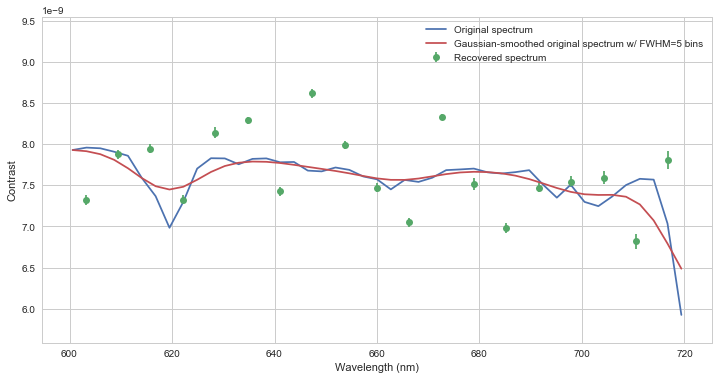

In [23]:
from crispy.tools.postprocessing import SNR_spectrum
from crispy.tools.reduction import calculateWaveList
signal = np.loadtxt(folder+"/average/signal.txt")
noise = np.loadtxt(folder+"/average/noise.txt")
# noise = np.loadtxt(folder+"/average/noise_no_rdi.txt")
# noise = np.loadtxt(folder+"/average/noise_no_source.txt")
lam_midpts,junk = calculateWaveList(par,method='optext')
wavelist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,45)
plt.figure(figsize=(20,8))
ratio_out = SNR_spectrum(lam_midpts,signal,noise,lam_contrast=wavelist,outfolder=par.exportDir+"/",
             FWHM=2*45./19.,FWHMdata=2,edges=1,ymargin=0.2,title='')
#np.savetxt(folder+"/average/ratio.txt",ratio_out)
plt.savefig(folder+'/average/SNR.png',dpi=300)


In [12]:
ref_star = fits.getdata(folder+'/average'+'/average_ref_star_detector_red_optext_flatfielded.fits')
target_star_planet = fits.getdata(folder+'/average'+'/average_target_star_detector_red_optext_flatfielded.fits')
target_star = fits.getdata(folder+'/average'+'/average_target_star_nosource_detector_red_optext_flatfielded.fits')
planet = target_star_planet - target_star
planet = fits.getdata(folder+'/average'+'/offaxis_planet_red_optext_flatfielded.fits')
rdi_residual = fits.getdata(folder+'/average'+"/lstsq_residual.fits")
trim = 31


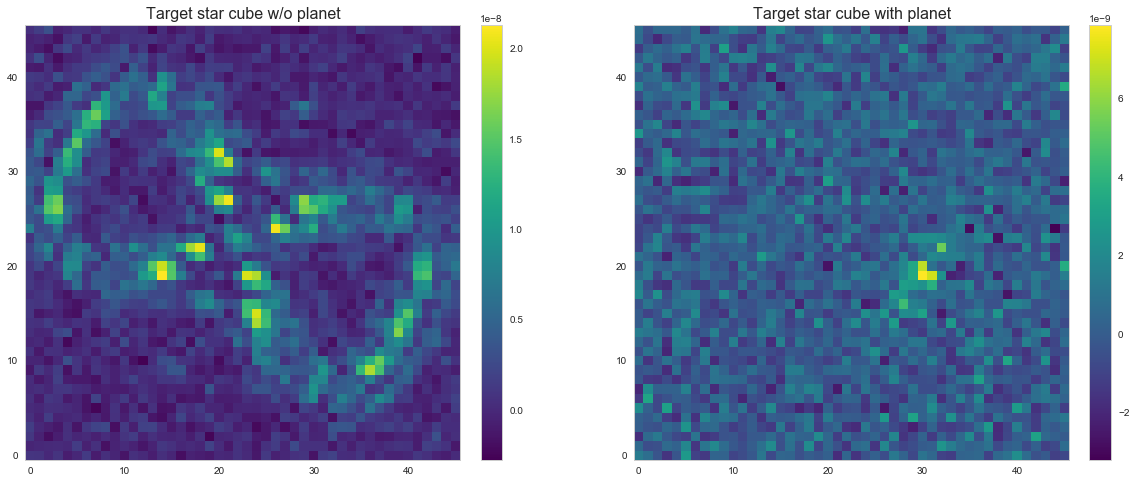

In [13]:
import ipywidgets
def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(target_star[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Target star cube w/o planet",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
    plt.subplot(122)
    plt.imshow(target_star_planet[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Target star cube with planet",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
ipywidgets.interact(plt_cubes_slices, wchan=(1,planet.shape[0]));

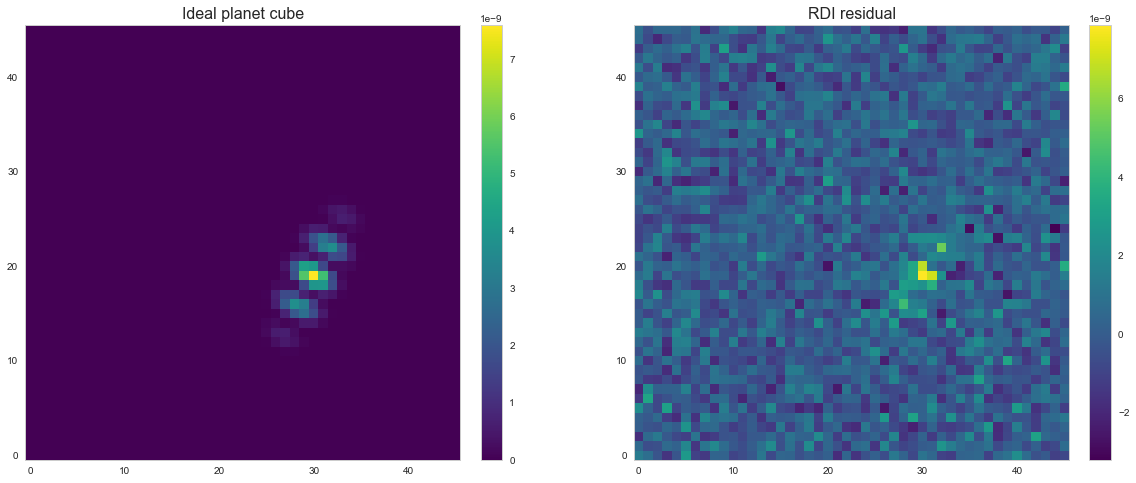

In [14]:
def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(planet[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Ideal planet cube",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
    plt.subplot(122)
    plt.imshow(rdi_residual[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("RDI residual",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
ipywidgets.interact(plt_cubes_slices, wchan=(1,planet.shape[0]));

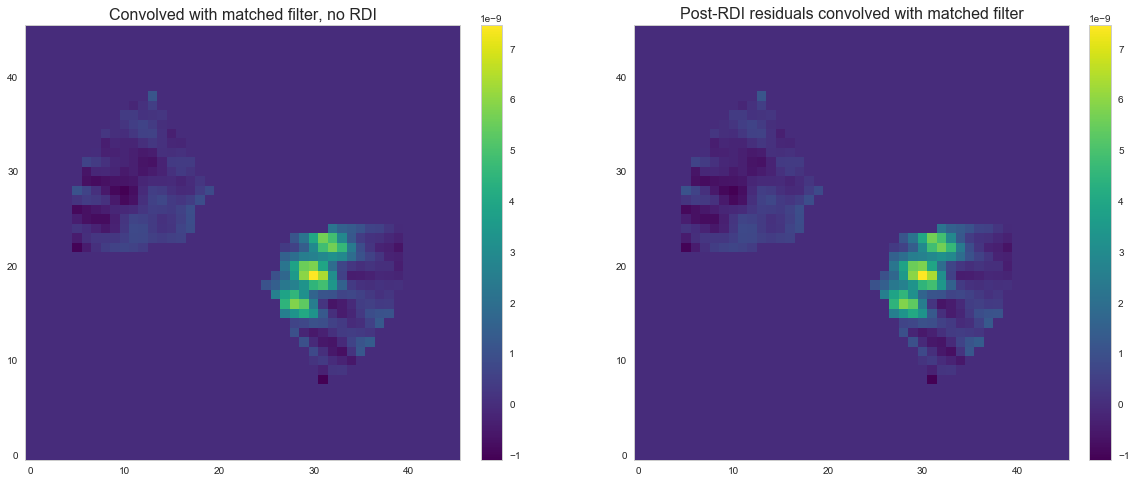

In [15]:
convolved_no_rdi_normalized = fits.getdata(folder+'/average'+'/convolved_no_rdi_normalized.fits')
convolved_normalized = fits.getdata(folder+'/average'+'/convolved_normalized.fits')


def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(convolved_no_rdi_normalized[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Convolved with matched filter, no RDI",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
    plt.subplot(122)
    plt.imshow(convolved_normalized[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Post-RDI residuals convolved with matched filter",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
ipywidgets.interact(plt_cubes_slices, wchan=(1,planet.shape[0]));

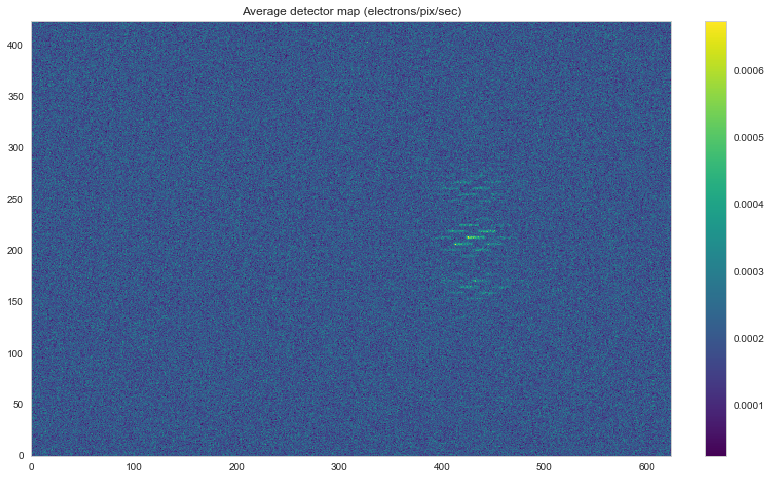

In [16]:
plt.figure(figsize=(15,8))
detector_map = fits.getdata(folder+'/average'+'/average_target_star_detector.fits')
plt.imshow(detector_map[300:-300,200:-200],cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Average detector map (electrons/pix/sec)")
plt.grid(False)

<Container object of 3 artists>

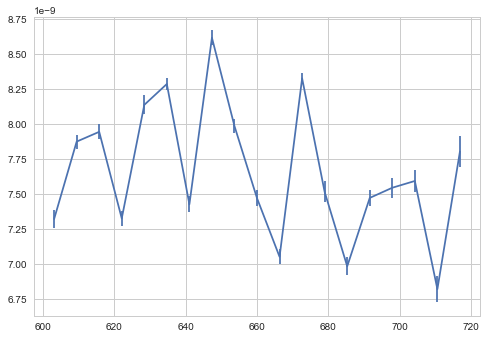

In [17]:
plt.errorbar(lam_midpts,signal,yerr=noise)

## Manual RDI on data products, to test that it works

(19, 108, 108)
[[  4.00175421e-10  -4.36991402e-03]
 [  4.51845980e-10  -8.38348404e-03]
 [  5.48909558e-10  -1.30189753e-02]
 [  4.27846355e-10  -8.49067876e-03]
 [  4.04818739e-10  -1.12300927e-02]
 [  4.44911779e-10  -9.65343778e-03]
 [  5.37977462e-10  -1.21260962e-02]
 [  4.40206168e-10  -1.09221181e-02]
 [  5.22575967e-10  -7.46626183e-03]
 [  4.49849875e-10  -6.89945540e-03]
 [  4.80678653e-10  -5.24495179e-03]
 [  5.41870880e-10  -5.14616896e-03]
 [  5.26365108e-10  -9.32292868e-03]
 [  4.91838309e-10  -3.39171229e-03]
 [  4.57694515e-10  -4.97873250e-03]
 [  4.76419553e-10  -5.23268286e-03]
 [  5.01197683e-10  -3.49716754e-03]
 [  4.41733082e-10  -4.33285494e-03]
 [  4.19689400e-10  -5.83538223e-03]]
(19, 2)


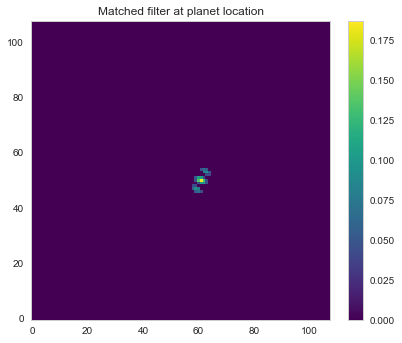

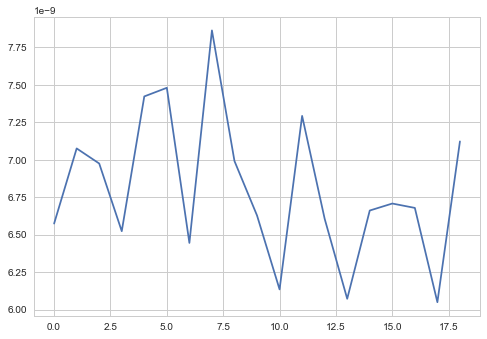

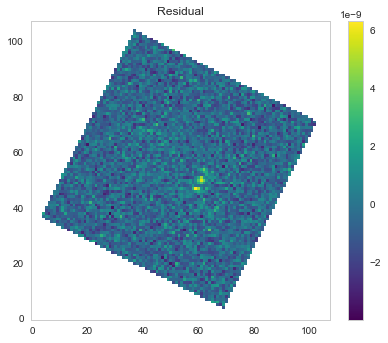

In [18]:
OA = 65
IWA = 2.5
OWA = 9.
lamc=660.
ref_star = fits.open(folder+'/average'+'/average_ref_star_detector_red_optext_flatfielded.fits')[1]
target_star_planet = fits.open(folder+'/average'+'/average_target_star_detector_red_optext_flatfielded.fits')[1]
target_star = fits.open(folder+'/average'+'/average_target_star_nosource_detector_red_optext_flatfielded.fits')[1]

ydim,xdim = ref_star.data[0].shape
mask,scratch = bowtie(ref_star.data[0],ydim//2-1,xdim//2,openingAngle=OA,
        clocking=-par.philens*180./np.pi,
        IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        export=None,twomasks=False)    

offaxis = fits.open(folder+'/average'+'/offaxis_planet_red_optext.fits')[1]
print offaxis.data.shape
matched_filter = mf(offaxis,mask,0.2)
plt.imshow(matched_filter[10],cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Matched filter at planet location")
plt.grid(False)
coefs,est = scale2imgs(target_star_planet,
                            ref_star,
                            bowtie_mask = mask,
                            returndiff = False,
                            returnest = True)

rdi_planet = target_star_planet.data - est
print coefs
mf_rdi_planet = matched_filter*rdi_planet
rdi_planet_spectrum = np.nansum(np.nansum(mf_rdi_planet, axis=2), axis=1)
plt.figure()
print coefs.shape
plt.plot(rdi_planet_spectrum)
plt.figure()
plt.imshow(rdi_planet[10],cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Residual")
plt.grid(False)


(334,)


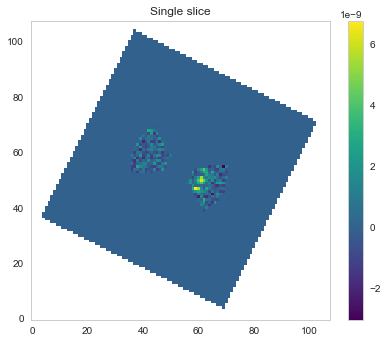

In [19]:
targetslice = np.reshape(target_star_planet.data[10,mask],-1)
print targetslice.shape
targetslice = target_star_planet.data[10,:]
plt.imshow(targetslice*mask,cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Single slice")
plt.grid(False)


(2, 334)
334 (19, 108, 108) (19, 334)


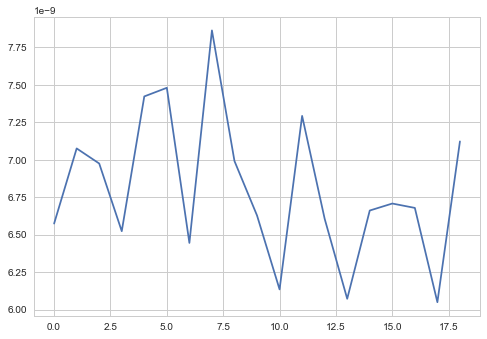

In [20]:
import scipy
data_mask,scratch = bowtie(ref_star.data[0],ydim//2-1,xdim//2,openingAngle=OA,
        clocking=-par.philens*180./np.pi,
        IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        export=None,twomasks=False)    
data_ind = np.nonzero(data_mask)
nan_ind = np.nonzero(~data_mask)
N_pix = len(data_ind[0])
N_mask = len(nan_ind[0])
print np.array(data_ind).shape

data_mask_nan = np.zeros(data_mask.shape)       
data_mask_nan[nan_ind[0][:], nan_ind[1][:]] = np.nan
data_mask_nan[data_ind[0][:], data_ind[1][:]] = True

masked_ref_star = data_mask_nan*ref_star.data
masked_target_star = data_mask_nan*target_star.data
masked_target_star_planet = data_mask_nan*target_star_planet.data

target_star_vec = target_star.data[:,data_ind[0],data_ind[1]]
target_star_planet_vec = target_star_planet.data[:,data_ind[0],data_ind[1]]
ref_star_vec = ref_star.data[:,data_ind[0],data_ind[1]]

Nw = ref_star.data.shape[0]
linregress_coeff = np.zeros((Nw, 2))
target_star_est_vec = np.zeros_like(target_star_planet_vec)
target_star_est = np.zeros_like(ref_star.data)

for wi in range(Nw):
    b, a, _, _, _ = scipy.stats.linregress(ref_star_vec[wi,:], target_star_planet_vec[wi,:])
    linregress_coeff[wi, 0] = a
    linregress_coeff[wi, 1] = b
    target_star_est_vec[wi] = a + b*ref_star_vec[wi]
    #target_star_est_vec[wi] = b*ref_star_vec[wi]

print N_pix,target_star_est.shape,target_star_est_vec.shape

for ii in range(N_pix):
    target_star_est[:, data_ind[0][ii], data_ind[1][ii]] = target_star_est_vec[:,ii]
for ii in range(N_mask):
    target_star_est[:, nan_ind[0][ii], nan_ind[1][ii]] = np.nan

rdi_planet = target_star_planet.data - target_star_est
mf_rdi_planet = matched_filter*rdi_planet
rdi_planet_spectrum = np.nansum(np.nansum(mf_rdi_planet, axis=2), axis=1)
plt.figure()
plt.plot(rdi_planet_spectrum)


In [21]:
outkey = fits.HDUList(fits.PrimaryHDU(matched_filter))
outkey.writeto(folder+'/average'+'/matched_filter_test.fits', clobber=True)


In [22]:
ref_star_average = Image(folder+'/average/average_ref_star_detector.fits').data
print np.mean(ref_star_average)

crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0_t1000/average/average_ref_star_detector.fits
0.000267235
